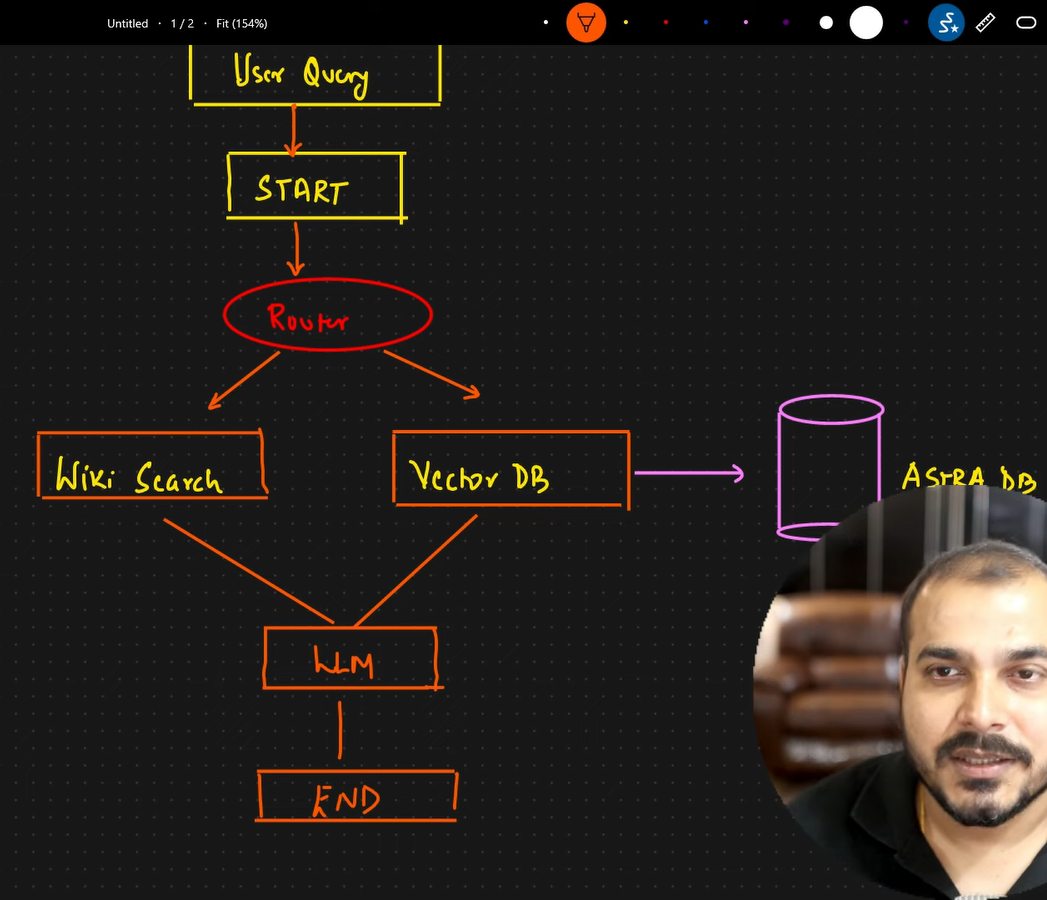

In [ ]:
## Signed up to Datastax astra DB to access the vector database --> created a serverless vector DB and saved it DB ID + created a new admin user token and downloaded the JSON file
!pip install langchain langgraph cassio
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
from dotenv import load_dotenv
import cassio, os

load_dotenv()

##connection of Astra DB
ASTRA_DB_TOKEN = "<ASTRA DB TOKEN>"
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")
cassio.init(token=ASTRA_DB_TOKEN, database_id = ASTRA_DB_ID)

##token=ASTRA_DB_TOKEN → Authentication token for secure access to Astra DB.
##database_id=ASTRA_DB_ID → The unique identifier for your Astra DB instance.

In [ ]:
!pip install -U langchain_community langchain_groq langchainhub tiktoken langchain langgraph langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

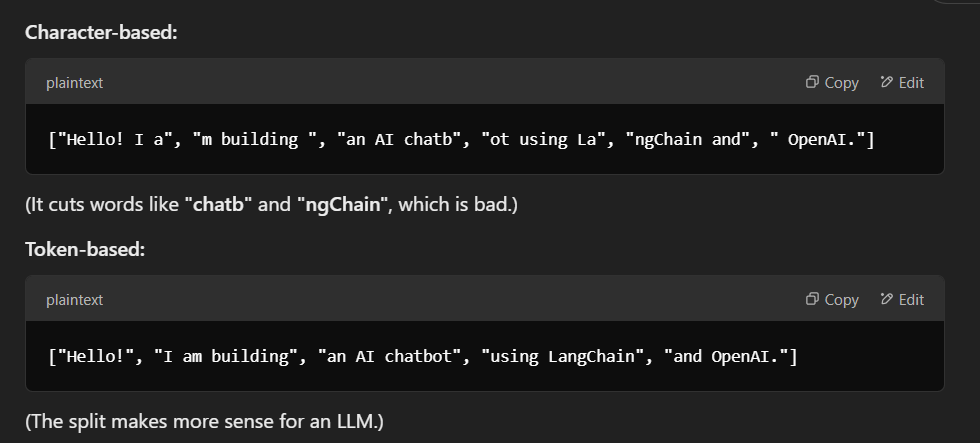

In [ ]:
##build index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

#Docs to index
urls = [
     "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

#load the urls
docs = [WebBaseLoader(url).load() for url in urls ]   # --> here, docs becomes a list of lists
doc_list = [item for sublist in docs for item in sublist]   # --> here, it flattens docs into a single list
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap =0)
docs_split = text_splitter.split_documents(doc_list)

# .from_tiktoken_encoder() is used to ensure that the text splitting is based on token count instead of character count.

what this does --> doc_list = [item for sublist in docs for item in sublist]

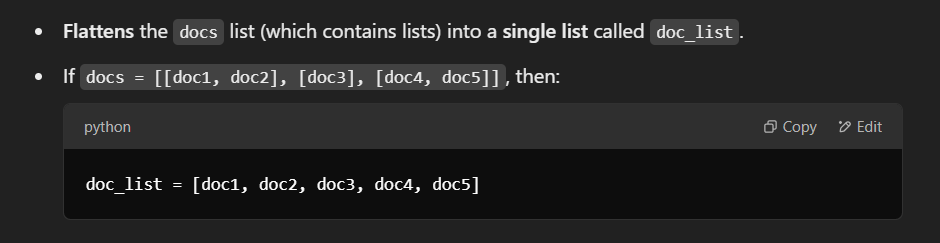

In [ ]:
!pip install python-dotenv

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [ ]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(embedding=embeddings,
                               table_name="qa_mini_demo",
                               session=None,
                               keyspace=None
                               )



In [ ]:
#need to store data into the created table
#stores documents in Astra DB (as a vector database) and wraps it inside a LangChain-compatible index for easy retrieval.

from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_split)
print("Inserted %i headlines."% len(docs_split))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)


Inserted 88 headlines.


In [ ]:
#converts the Astra DB vector store into a LangChain-compatible retriever
retriever =  astra_vector_store.as_retriever()
retriever.invoke("What is an agent?")

[Document(id='55006c595e75424c85e74110628d3c52', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

ASTRA DB CONFIGURATION AND ITS INTEGRATION WITH CREATION OF EMBEDDINGS FOR THE RESPECTIVE DOCS IS COMPLETED HERE.


In [ ]:
#Langgraph application

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal


In [ ]:
#To route a user query to appropriate data source --> either a vector database (like Astra DB) or Wikipedia search—based on the nature of the query.

class RouteQuery(BaseModel):
  """Route a user query to the most relevant data source"""

  datasource: Literal["vectorstore","wiki_search"] = Field(                       #restricts datasource to these 2 choices
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore "
  )

In [ ]:
from langchain_groq import ChatGroq
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name="gemma2-9b-it")

#now have to integrate route query with our llm model
structured_llm_router = llm.with_structured_output(RouteQuery)

#Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
the vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics and topics related to it. Otherwise, use wiki search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
    ("system",system),
    ("human","{question}")
    ]
)

question_router = route_prompt | structured_llm_router

**Why structured output?**
--> Prevents LLM hallucinations by restricting possible outputs.

**system message** --> acts as instruction to LLM

**ChatPromptTemplate.from_messages([...])** → Defines a prompt template with dynamic input.
**route_prompt | structured_llm_router** → Pipes the prompt into the LLM router.

In [ ]:
print(
    question_router.invoke(
    {
        "question":"What is an agent?"
    }
)
    )

datasource='vectorstore'


In [ ]:
print(
    question_router.invoke(
    {
        "question":"Who is Henry Cavill?"
    }
)
    )

datasource='wiki_search'


In [ ]:
!pip install langchain_community
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=1ac1f96f5ee62ec5ffe153e4d0aeaba7045d12aa01ccb0dface8773d5a062258
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)


In [ ]:
wiki.run("Tell me about Henry Cavill")

"Page: Superman in film\nSummary: DC Comics's Superman franchise, based on the character of the same name created by Jerry Siegel and Joe Shuster in June 1938, has seen the release of various films sinc"

In [ ]:
#AI Agent application using Langgraph

from typing import Annotated
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """
  Represents the state of the graph

  Attributes:
      question: question
      generation:  LLM generation
      documents: list of documents
  """

  question: str
  generation: str
  documents: list[str]



In [ ]:
from langchain.schema import Document

def retrieve(state):
  print("\n\n---Retreive--\n\n")
  questions = state["question"]

  #Retreival
  documents = retriever.invoke(questions)
  return {"documents":documents,"question":questions}



In [ ]:
def wiki_search(state):
  print("\n---Wikipedia---\n\n")
  question = state["question"]
  print(question)

  #wiki search
  docs=wiki.invoke({"query":question})

  #print(docs["summary"])
  wiki_results = docs
  wiki_results = Document(page_content=wiki_results)

  return {"documents": wiki_results, "question":question}



In [ ]:
#Routing functionality

def route_question(state):
  print("\n---ROUTE QUESTION---\n\n")
  question=state["question"]
  source=question_router.invoke({"question":question})

  if source.datasource == "wiki_search":
    print("--ROUTE QUESTION TO WIKIPEDIA--\n")
    return "wiki_search"
  elif source.datasource == "vectorstore":
    print("--ROUTE QUESTION TO RAG--\n")
    return "vectorstore"

In [ ]:
#langgraph flow
from langgraph.graph import StateGraph, END, START

workflow = StateGraph(GraphState)

#Define nodes
workflow.add_node("wiki_search",wiki_search)              #websearch
workflow.add_node("retrieve",retrieve)                    #vectorDB search

#Build the graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve",
    },
)

workflow.add_edge("retrieve",END)
workflow.add_edge("wiki_search",END)

#compile the graph

graph = workflow.compile()


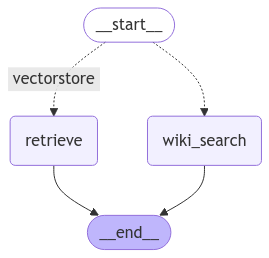

In [ ]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])


---ROUTE QUESTION---




--ROUTE QUESTION TO RAG--



---Retreive--


"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n

<ipython-input-61-4ffa7e770307>:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "shah rukh khan"
}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])


---ROUTE QUESTION---


--ROUTE QUESTION TO WIKIPEDIA--


---Wikipedia---


shah rukh khan
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Refe')
